<a href="https://colab.research.google.com/github/gouhar1512/Algorithms/blob/master/AutoEncoder_CovidDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3629, done.
remote: Total 3629 (delta 0), reused 0 (delta 0), pack-reused 3629
Receiving objects: 100% (3629/3629), 632.96 MiB | 29.14 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.
Checking out files: 100% (1173/1173), done.


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

size = 64
def getImagesURL():
  imageList = glob.glob("./covid-chestxray-dataset/images/*.jpg")
  return imageList

def load_img(url):
  img = cv2.imread(url).astype(np.float32) / 255
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(size, size))
  return img

def display_img(img):
  plt.imshow(img, interpolation='none', cmap='gray')
  plt.show()

def loadAllImages(imageList):
  # size = len(imageList)
  cnt = len(imageList)
  allImages = np.array([])
  for i in range(0,cnt):
    url = imageList[i]
    img = load_img(url)
    
    # print(img)
    allImages = np.append(allImages, img)
  allImages = allImages.reshape(cnt,size,size)
  return allImages

imageList = getImagesURL()
allImages = loadAllImages(imageList)

def addNoise(img):
  mean = 0.0   # some constant
  std = 15/255    # some constant (standard deviation)
  noisy_img = img + np.random.normal(mean, std, img.shape)
  noisy_img_clipped = np.clip(noisy_img, 0, 1)
  return noisy_img

def addNoiseToAllImages(allImages):
  noisy_images = np.copy(allImages)
  idx = 0
  for img in allImages:
    noisy_images[idx] = addNoise(img)
    idx = idx+1
  return noisy_images

from math import log10,sqrt
def mse_psnr(clean_img, noisy_img):
    l=2
    mse = np.mean((clean_img-noisy_img)**2)
    if mse==0:
        psnr=100
    else:
        psnr = 20*log10((l-1)/sqrt(mse))
    return mse, psnr

allNoisyImages = addNoiseToAllImages(allImages)
from sklearn.model_selection import train_test_split
x_train_noisy, x_test_noisy, x_train_clean, x_test_clean = train_test_split(allNoisyImages, allImages, test_size=0.30, random_state=42)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)


In [16]:
# Network parameters
image_size = 64
input_shape = (image_size, image_size, 1)
batch_size = 10
kernel_size = 3
latent_dim = 32
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [16, 32]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train_clean,
                validation_data=(x_test_noisy, x_test_clean),
                epochs=50,
                batch_size=batch_size)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                262176    
Total params: 266,976
Trainable params: 266,976
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output 

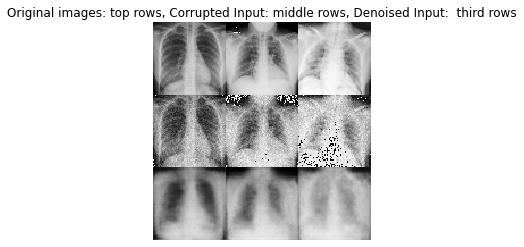

In [11]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)
x_decoded = x_decoded.reshape((x_test_noisy.shape))
# Display the 1st 8 corrupted and denoised images
rows, cols = 1,3
num = rows * cols
imgs = np.concatenate([x_test_clean[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()



In [12]:
print(mse_psnr(x_test_clean[0], x_test_noisy[0]))
print(mse_psnr(x_test_clean[0], x_decoded[0]))

(0.0034945983612619975, 24.56602731080232)
(0.011820583745235315, 19.273610758173177)
